In [1]:
# !gdown --id

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=111MIyXRBIRLMILMaiUZHYxEgJ1qnR3YO
From (redirected): https://drive.google.com/uc?id=111MIyXRBIRLMILMaiUZHYxEgJ1qnR3YO&confirm=t&uuid=b98e640e-fe4b-4a3e-ae77-5a4d9f2dff87
To: /content/data_project_DL2.zip
100% 5.21G/5.21G [01:36<00:00, 54.2MB/s]


In [ ]:
# UPLOAD ZIP from my goodle drive to colab

In [2]:
# import os
# import shutil

# zip_file_path = '/content/data_project_DL2.zip'
# extract_to_path = '/content/'

# print(f"Розпаковка {zip_file_path} до {extract_to_path}")
# !unzip -q {zip_file_path} -d {extract_to_path}

# extracted_contents = os.listdir(extract_to_path)

# possible_top_level_dir = None
# for item in extracted_contents:
#     if os.path.isdir(os.path.join(extract_to_path, item)) and ('data_project_DL2' in item or 'train_images' in os.listdir(os.path.join(extract_to_path, item))):
#         possible_top_level_dir = item
#         break

# if possible_top_level_dir:
#     source_dir = os.path.join(extract_to_path, possible_top_level_dir)
#     print(f"Переміщення вмісту з {source_dir} до {extract_to_path}")

#     for item in os.listdir(source_dir):
#         shutil.move(os.path.join(source_dir, item), extract_to_path)

#     os.rmdir(source_dir)
#     print(f"Видалення порожньої директорії: {source_dir}")
# else:
#     print("Верхній рівень директорії не знайдено, припускається, що файли вже в корені.")

# os.remove(zip_file_path)
# print(f"Видалення zip-файлу: {zip_file_path}")

# print("\nВміст поточної директорії після розпакування:")
# !ls -F /content/


Розпаковка /content/data_project_DL2.zip до /content/
Переміщення вмісту з /content/recodai-luc-scientific-image-forgery-detection до /content/
Видалення порожньої директорії: /content/recodai-luc-scientific-image-forgery-detection
Видалення zip-файлу: /content/data_project_DL2.zip

Вміст поточної директорії після розпакування:
sample_data/	       test_images/	 UNet_ResNet34_Pretrained_E10.pt
sample_submission.csv  train_images/	 UNet_ResNet34_SCSE_ASPP_E10.pt
supplemental_images/   train_masks/	 UNet_VGG11_NoPretrain_E10.pt
supplemental_masks/    UNet_Base_E10.pt


In [3]:
import os
import shutil
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# --- 0. CONFIGURATION ---
class CFGA:
    # Source paths (adjust these if your raw data is elsewhere)
    raw_img_dir = Path('/content/train_images')
    raw_mask_dir = Path('/content/train_masks')

    root_dir = Path('/content/data_patches')
    patch_size = 512              # Divisible by 32 for ResNet encoder
    batch_size = 16
    lr = 1e-4
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 4               # Set to 0 on Windows to avoid slow multiprocessing startup
    pin_memory = True
    model_name = "UNet_Base"
    target_limit = 20000
    meta_cache = Path("train_metadata.json")

# --- 1. DATA ORGANIZATION ---
def organize_data():
    """Splits raw images into train/val folders and maps .npy masks."""
    print("📂 Organizing data and splitting into Train/Val...")
    for split in ['train', 'val']:
        for cat in ['authentic', 'forged', 'masks']:
            (CFGA.root_dir / split / cat).mkdir(parents=True, exist_ok=True)

    # Process Authentic
    auth_files = list((CFGA.raw_img_dir / 'authentic').glob('*'))
    a_train, a_val = train_test_split(auth_files, test_size=0.2, random_state=42)

    # Process Forged
    forged_files = list((CFGA.raw_img_dir / 'forged').glob('*'))
    f_train, f_val = train_test_split(forged_files, test_size=0.2, random_state=42)

    def distribute_files(files, split, is_forged=False):
        for fpath in files:
            dest_cat = 'forged' if is_forged else 'authentic'
            shutil.copy(fpath, CFGA.root_dir / split / dest_cat / fpath.name)
            if is_forged:
                mask_name = fpath.stem + '.npy'
                m_path = CFGA.raw_mask_dir / mask_name
                if m_path.exists():
                    shutil.copy(m_path, CFGA.root_dir / split / 'masks' / mask_name)

    distribute_files(a_train, 'train')
    distribute_files(a_val, 'val')
    distribute_files(f_train, 'train', is_forged=True)
    distribute_files(f_val, 'val', is_forged=True)
    print("✅ Transfer Complete.")

# --- 2. TRAINING PATCH SCANNER ---
def scan_and_visualize_train(root_dir, patch_size, target_limit):
    """Scans TRAIN folder using exact stride and threshold logic."""
    print(f"\n🔍 Scanning Train patches (Size: {patch_size})...")
    train_base = root_dir / "train"
    patch_metadata = {'authentic': [], 'forged': []}

    for is_forged in [True, False]:
        category = 'forged' if is_forged else 'authentic'
        folder = train_base / category
        files = sorted([f for f in folder.glob('*') if not f.name.startswith('.')])

        count = 0
        for fpath in tqdm(files, desc=f"Scanning {category}"):
            if count >= target_limit: break
            try:
                if is_forged:
                    m_path = train_base / "masks" / (fpath.stem + ".npy")
                    mask = np.load(m_path)
                    if mask.ndim == 3: mask = mask[0]
                    h, w = mask.shape
                else:
                    img_info = cv2.imread(str(fpath))
                    if img_info is None: continue
                    h, w = img_info.shape[:2]

                stride = patch_size if is_forged else patch_size * 2

                for y in range(0, h, stride):
                    for x in range(0, w, stride):
                        if is_forged:
                            m_patch = mask[y:y+patch_size, x:x+patch_size]
                            if np.sum(m_patch > 0) < 50: continue

                        patch_metadata[category].append((fpath, x, y, patch_size, is_forged))
                        count += 1
                        if count >= target_limit: break
                    if count >= target_limit: break
            except: continue

    print(f"📊 TRAIN COUNTS: Forged: {len(patch_metadata['forged'])}, Auth: {len(patch_metadata['authentic'])}")
    return patch_metadata

# --- 3. VALIDATION PROCESSING LOGIC ---
def process_val_image(img, mask=None, target_size=None):
    if target_size is None:
        target_size = CFGA.patch_size

    """Square center crop and resize/pad logic for Validation."""
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x, start_y = (w - min_dim) // 2, (h - min_dim) // 2

    img_cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]
    mask_cropped = mask[start_y:start_y+min_dim, start_x:start_x+min_dim] if mask is not None else None

    if min_dim < target_size:
        pad = target_size - min_dim
        img_final = cv2.copyMakeBorder(img_cropped, 0, pad, 0, pad, cv2.BORDER_CONSTANT, value=0)
        mask_final = cv2.copyMakeBorder(mask_cropped, 0, pad, 0, pad, cv2.BORDER_CONSTANT, value=0) if mask is not None else None
    else:
        img_final = cv2.resize(img_cropped, (target_size, target_size), interpolation=cv2.INTER_AREA)
        mask_final = cv2.resize(mask_cropped, (target_size, target_size), interpolation=cv2.INTER_NEAREST) if mask is not None else None

    return img_final, mask_final

# --- 4. VISUALIZATION ---
def visualize_results(train_meta, target_size):
    """Plots Training patches and Validation square crops."""
    print("\n🎨 Generating Visualizations...")
    fig, axes = plt.subplots(2, 6, figsize=(20, 8))

    # Plot 3 Train Forged, 3 Train Auth
    train_samples = train_meta['forged'][:3] + train_meta['authentic'][:3]
    for i, (fpath, x, y, size, is_forged) in enumerate(train_samples):
        img = cv2.cvtColor(cv2.imread(str(fpath)), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        y_e, x_e = min(y+size, h), min(x+size, w)
        p_img = img[y:y_e, x:x_e]
        if p_img.shape[:2] != (size, size):
            p_img = cv2.copyMakeBorder(p_img, 0, size-p_img.shape[0], 0, size-p_img.shape[1], cv2.BORDER_CONSTANT)

        axes[0, i].imshow(p_img)
        axes[0, i].set_title(f"TRAIN {'F' if is_forged else 'A'}")
        axes[0, i].axis('off')

    # Plot 6 Validation center crops (3F, 3A)
    val_base = CFGA.root_dir / "val"
    val_samples = sorted(list((val_base / "forged").glob("*")))[:3] + sorted(list((val_base / "authentic").glob("*")))[:3]
    for i, fpath in enumerate(val_samples):
        is_f = "forged" in str(fpath)
        img = cv2.cvtColor(cv2.imread(str(fpath)), cv2.COLOR_BGR2RGB)
        mask = None
        if is_f:
            m_p = val_base / "masks" / (fpath.stem + ".npy")
            if m_p.exists():
                mask = np.load(m_p)
                if mask.ndim == 3: mask = mask[0]

        v_img, v_mask = process_val_image(img, mask, CFGA.patch_size)
        axes[1, i].imshow(v_img if i%2==0 else (v_mask if v_mask is not None else v_img), cmap='magma' if i%2!=0 else None)
        axes[1, i].set_title(f"VAL {'F' if is_f else 'A'}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig("data_preview.png")
    print("📈 Preview saved as 'data_preview.png'")
    plt.show()

In [10]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.5 MB/s eta 0:00:00


In [11]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import albumentations as A
import warnings
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch, rates=(1, 6, 12, 18)):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        ])
        for r in rates[1:]:
            self.branches.append(nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            ))
        self.project = nn.Sequential(
            nn.Conv2d(out_ch * len(rates), out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        feats = [b(x) for b in self.branches]
        x = torch.cat(feats, dim=1)
        return self.project(x)

class UNet_ResNet34_SCSE_ASPP(nn.Module):
    def __init__(self, in_channels=3, classes=1, encoder_weights="imagenet"):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            decoder_attention_type="scse",
        )

        bottleneck_ch = self.unet.encoder.out_channels[-1]
        self.aspp = ASPP(bottleneck_ch, bottleneck_ch)

    def forward(self, x):
        features = self.unet.encoder(x)
        features[-1] = self.aspp(features[-1])

        try:
            decoder_output = self.unet.decoder(*features)
        except TypeError:
            decoder_output = self.unet.decoder(features)

        masks = self.unet.segmentation_head(decoder_output)
        return masks


def get_model_unet_res_att_aspp():
    return UNet_ResNet34_SCSE_ASPP(
        in_channels=3,
        classes=1,
        encoder_weights="imagenet",
    )


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNetBase(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base=64):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(in_channels, base);      self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2);           self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4);         self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base*4, base*8);         self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base*8, base*16)

        # Decoder
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2); self.conv4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2);  self.conv3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2);  self.conv2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2);    self.conv1 = DoubleConv(base*2, base)

        self.head = nn.Conv2d(base, out_channels, 1)

    @staticmethod
    def _center_crop(enc_feat, target_hw):
        _, _, h, w = enc_feat.shape
        th, tw = target_hw
        if (h, w) == (th, tw):
            return enc_feat
        y1 = max((h - th) // 2, 0)
        x1 = max((w - tw) // 2, 0)
        return enc_feat[:, :, y1:y1+th, x1:x1+tw]

    def forward(self, x):
        # Encoder
        e1 = self.down1(x)
        e2 = self.down2(self.pool1(e1))
        e3 = self.down3(self.pool2(e2))
        e4 = self.down4(self.pool3(e3))
        b  = self.bottleneck(self.pool4(e4))

        # Decoder (crop skip if needed)
        d4 = self.up4(b);  d4 = self.conv4(torch.cat([self._center_crop(e4, d4.shape[-2:]), d4], dim=1))
        d3 = self.up3(d4); d3 = self.conv3(torch.cat([self._center_crop(e3, d3.shape[-2:]), d3], dim=1))
        d2 = self.up2(d3); d2 = self.conv2(torch.cat([self._center_crop(e2, d2.shape[-2:]), d2], dim=1))
        d1 = self.up1(d2); d1 = self.conv1(torch.cat([self._center_crop(e1, d1.shape[-2:]), d1], dim=1))

        return self.head(d1)  # logits


In [20]:
organize_data()

# --- 3. PATCH RETRIEVER (EXACT SAME AS ORIGINAL) ---
print("🚀 Starting patch extraction logic...")
train_metadata = scan_and_visualize_train(root_dir=CFGA.root_dir, patch_size=CFGA.patch_size, target_limit=CFGA.target_limit)

all_f, all_a = train_metadata['forged'], train_metadata['authentic']
val_root = CFGA.root_dir / "val"
val_f = [(f, 0, 0, CFGA.patch_size, True) for f in (val_root / "forged").glob("*")]
val_a = [(f, 0, 0, CFGA.patch_size, False) for f in (val_root / "authentic").glob("*")]

train_trans = A.Compose([A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])
val_trans = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

half = CFGA.batch_size // 2
loaders = {
    'train_f': DataLoader(LeanDataset(all_f, 'train', train_trans), batch_size=half, shuffle=True, num_workers=CFGA.num_workers, pin_memory=CFGA.pin_memory),
    'train_a': DataLoader(LeanDataset(all_a, 'train', train_trans), batch_size=half, shuffle=True, num_workers=CFGA.num_workers, pin_memory=CFGA.pin_memory),
    'val_f': DataLoader(LeanDataset(val_f, 'val', val_trans), batch_size=half, shuffle=False),
    'val_a': DataLoader(LeanDataset(val_a, 'val', val_trans), batch_size=half, shuffle=False)
}
print(f"✅ Setup Complete! Training on {len(all_f)} Forged / {len(all_a)} Auth patches.")

📂 Organizing data and splitting into Train/Val...
✅ Transfer Complete.
🚀 Starting patch extraction logic...

🔍 Scanning Train patches (Size: 512)...


Scanning forged:   0%|          | 0/2200 [00:00<?, ?it/s]

Scanning authentic:   0%|          | 0/1901 [00:00<?, ?it/s]

📊 TRAIN COUNTS: Forged: 4294, Auth: 3862
✅ Setup Complete! Training on 4294 Forged / 3862 Auth patches.


In [ ]:
!pip install scienceplots

In [5]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def compare_models_bin_preds(
    models: dict,
    loader,
    device,
    n_images=8,
    thr=0.5,
    denorm_fn=None,
):
    batch = next(iter(loader))
    imgs, gts = batch
    imgs = imgs.to(device)
    gts  = gts.to(device)

    B = min(n_images, imgs.size(0))
    M = len(models)
    col_names = ["Image", "GT"] + [f"{name}\n(bin thr={thr})" for name in models.keys()]

    preds_bin = {}
    for name, model in models.items():
        model.eval()
        logits = model(imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs > thr).float()
        preds_bin[name] = preds[:, 0].detach().cpu()

    fig, axes = plt.subplots(B, 2 + M, figsize=(3.2 * (2 + M), 3.2 * B))
    if B == 1:
        axes = axes.reshape(1, -1)

    for j, t in enumerate(col_names):
        axes[0, j].set_title(t)

    for i in range(B):
        img_t = imgs[i].detach().cpu()
        if denorm_fn is not None:
            img_t = denorm_fn(img_t)

        img_np = img_t.permute(1, 2, 0).numpy()
        gt_np  = gts[i, 0].detach().cpu().numpy()

        axes[i, 0].imshow(img_np)
        axes[i, 0].axis("off")

        # GT
        axes[i, 1].imshow(gt_np, cmap="gray")
        axes[i, 1].axis("off")

        for k, name in enumerate(models.keys()):
            pb = preds_bin[name][i].numpy()
            axes[i, 2 + k].imshow(pb, cmap="gray")
            axes[i, 2 + k].axis("off")

    plt.tight_layout()
    plt.show()

In [32]:
import torch
from pathlib import Path

CKPTS = {
    "UNet_Base": "UNet_Base_E10.pt",
    "UNet_ResNet34_Pre": "UNet_ResNet34_Pretrained_E10.pt",
    "UNet_ResNet34_SCSE_ASPP": "UNet_ResNet34_SCSE_ASPP_E10.pt",
    "UNet_VGG11_NoPre": "UNet_VGG11_NoPretrain_E10.pt",
}

builders = {
    "UNet_Base": build_unet_base,
    "UNet_ResNet34_Pre": build_unet_resnet34_pretrained,
    "UNet_ResNet34_SCSE_ASPP": build_unet_resnet34_scse_aspp,
    "UNet_VGG11_NoPre": build_unet_vgg11_nopre,
}

def _extract_state_dict(ckpt):
    if isinstance(ckpt, dict) and len(ckpt) > 0 and all(torch.is_tensor(v) for v in ckpt.values()):
        return ckpt
    if isinstance(ckpt, dict):
        for key in ["state_dict", "model_state_dict", "model", "net", "weights"]:
            if key in ckpt and isinstance(ckpt[key], dict):
                return ckpt[key]
    return None

def _clean_keys(sd):
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
    if all(k.startswith("model.") for k in sd.keys()):
        sd = {k.replace("model.", "", 1): v for k, v in sd.items()}
    return sd

def load_model_checkpoint(path, device, build_fn, strict=False):
    ckpt = torch.load(path, map_location=device)

    if isinstance(ckpt, torch.nn.Module):
        return ckpt.to(device).eval()

    sd = _extract_state_dict(ckpt)
    if sd is None:
        raise ValueError(f"Can't find state_dict in: {path}")

    model = build_fn().to(device)
    sd = _clean_keys(sd)

    missing, unexpected = model.load_state_dict(sd, strict=strict)
    model.eval()

    print(f"[{path.name}] missing={len(missing)} unexpected={len(unexpected)}")
    if len(missing) > 0:
        print("  missing (first 10):", missing[:10])
    if len(unexpected) > 0:
        print("  unexpected (first 10):", unexpected[:10])

    return model

# ---- load all ----
models = {}
for name, fname in CKPTS.items():
    p = Path(fname)
    models[name] = load_model_checkpoint(p, CFGA.device, builders[name], strict=False)

print("Loaded:", list(models.keys()))


[UNet_Base_E10.pt] missing=0 unexpected=0
[UNet_ResNet34_Pretrained_E10.pt] missing=0 unexpected=0
[UNet_ResNet34_SCSE_ASPP_E10.pt] missing=0 unexpected=0
[UNet_VGG11_NoPretrain_E10.pt] missing=0 unexpected=0
Loaded: ['UNet_Base', 'UNet_ResNet34_Pre', 'UNet_ResNet34_SCSE_ASPP', 'UNet_VGG11_NoPre']


In [33]:
x, _ = next(iter(loaders["val_f"]))
x = x[:2].to(CFGA.device)
y = models["UNet_ResNet34_SCSE_ASPP"](x)
print(y.shape, y.min().item(), y.max().item())

torch.Size([2, 1, 512, 512]) -7.49599552154541 2.25520920753479


In [34]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def compare_models_bin_preds(
    models: dict,
    loader,
    device,
    n_images=10,
    thr=0.5,
    denorm_fn=None,
    overlay=False,
):

    imgs, gts = next(iter(loader))
    imgs = imgs.to(device)
    gts  = gts.to(device)  # (B,1,H,W)

    B = min(n_images, imgs.size(0))
    model_names = list(models.keys())
    M = len(model_names)

    preds_bin = {}
    for name in model_names:
        models[name].eval()
        logits = models[name](imgs)                 # (B,1,H,W)
        probs  = torch.sigmoid(logits)
        preds  = (probs > thr).float()
        preds_bin[name] = preds[:, 0].detach().cpu()  # (B,H,W)

    extra = M if overlay else 0
    ncols = 2 + M + extra

    fig, axes = plt.subplots(B, ncols, figsize=(3.2*ncols, 3.2*B))
    if B == 1:
        axes = axes.reshape(1, -1)

    # titles
    axes[0, 0].set_title("Image")
    axes[0, 1].set_title("GT")
    for j, name in enumerate(model_names):
        axes[0, 2 + j].set_title(f"{name}\nBIN thr={thr}")
    if overlay:
        for j, name in enumerate(model_names):
            axes[0, 2 + M + j].set_title(f"{name}\nOverlay")

    for i in range(B):
        img_t = imgs[i].detach().cpu()  # (C,H,W)
        if denorm_fn is not None:
            img_t = denorm_fn(img_t)
        img_np = img_t.permute(1,2,0).numpy()
        gt_np  = gts[i,0].detach().cpu().numpy()

        axes[i,0].imshow(img_np); axes[i,0].axis("off")
        axes[i,1].imshow(gt_np, cmap="gray"); axes[i,1].axis("off")

        for j, name in enumerate(model_names):
            pb = preds_bin[name][i].numpy()
            axes[i,2+j].imshow(pb, cmap="gray")
            axes[i,2+j].axis("off")

            if overlay:
                axes[i,2+M+j].imshow(img_np)
                axes[i,2+M+j].imshow(pb, cmap="Reds", alpha=0.35)
                axes[i,2+M+j].axis("off")

    plt.tight_layout()
    plt.show()

In [35]:
def denorm_imagenet(img_chw):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (img_chw * std + mean).clamp(0, 1)

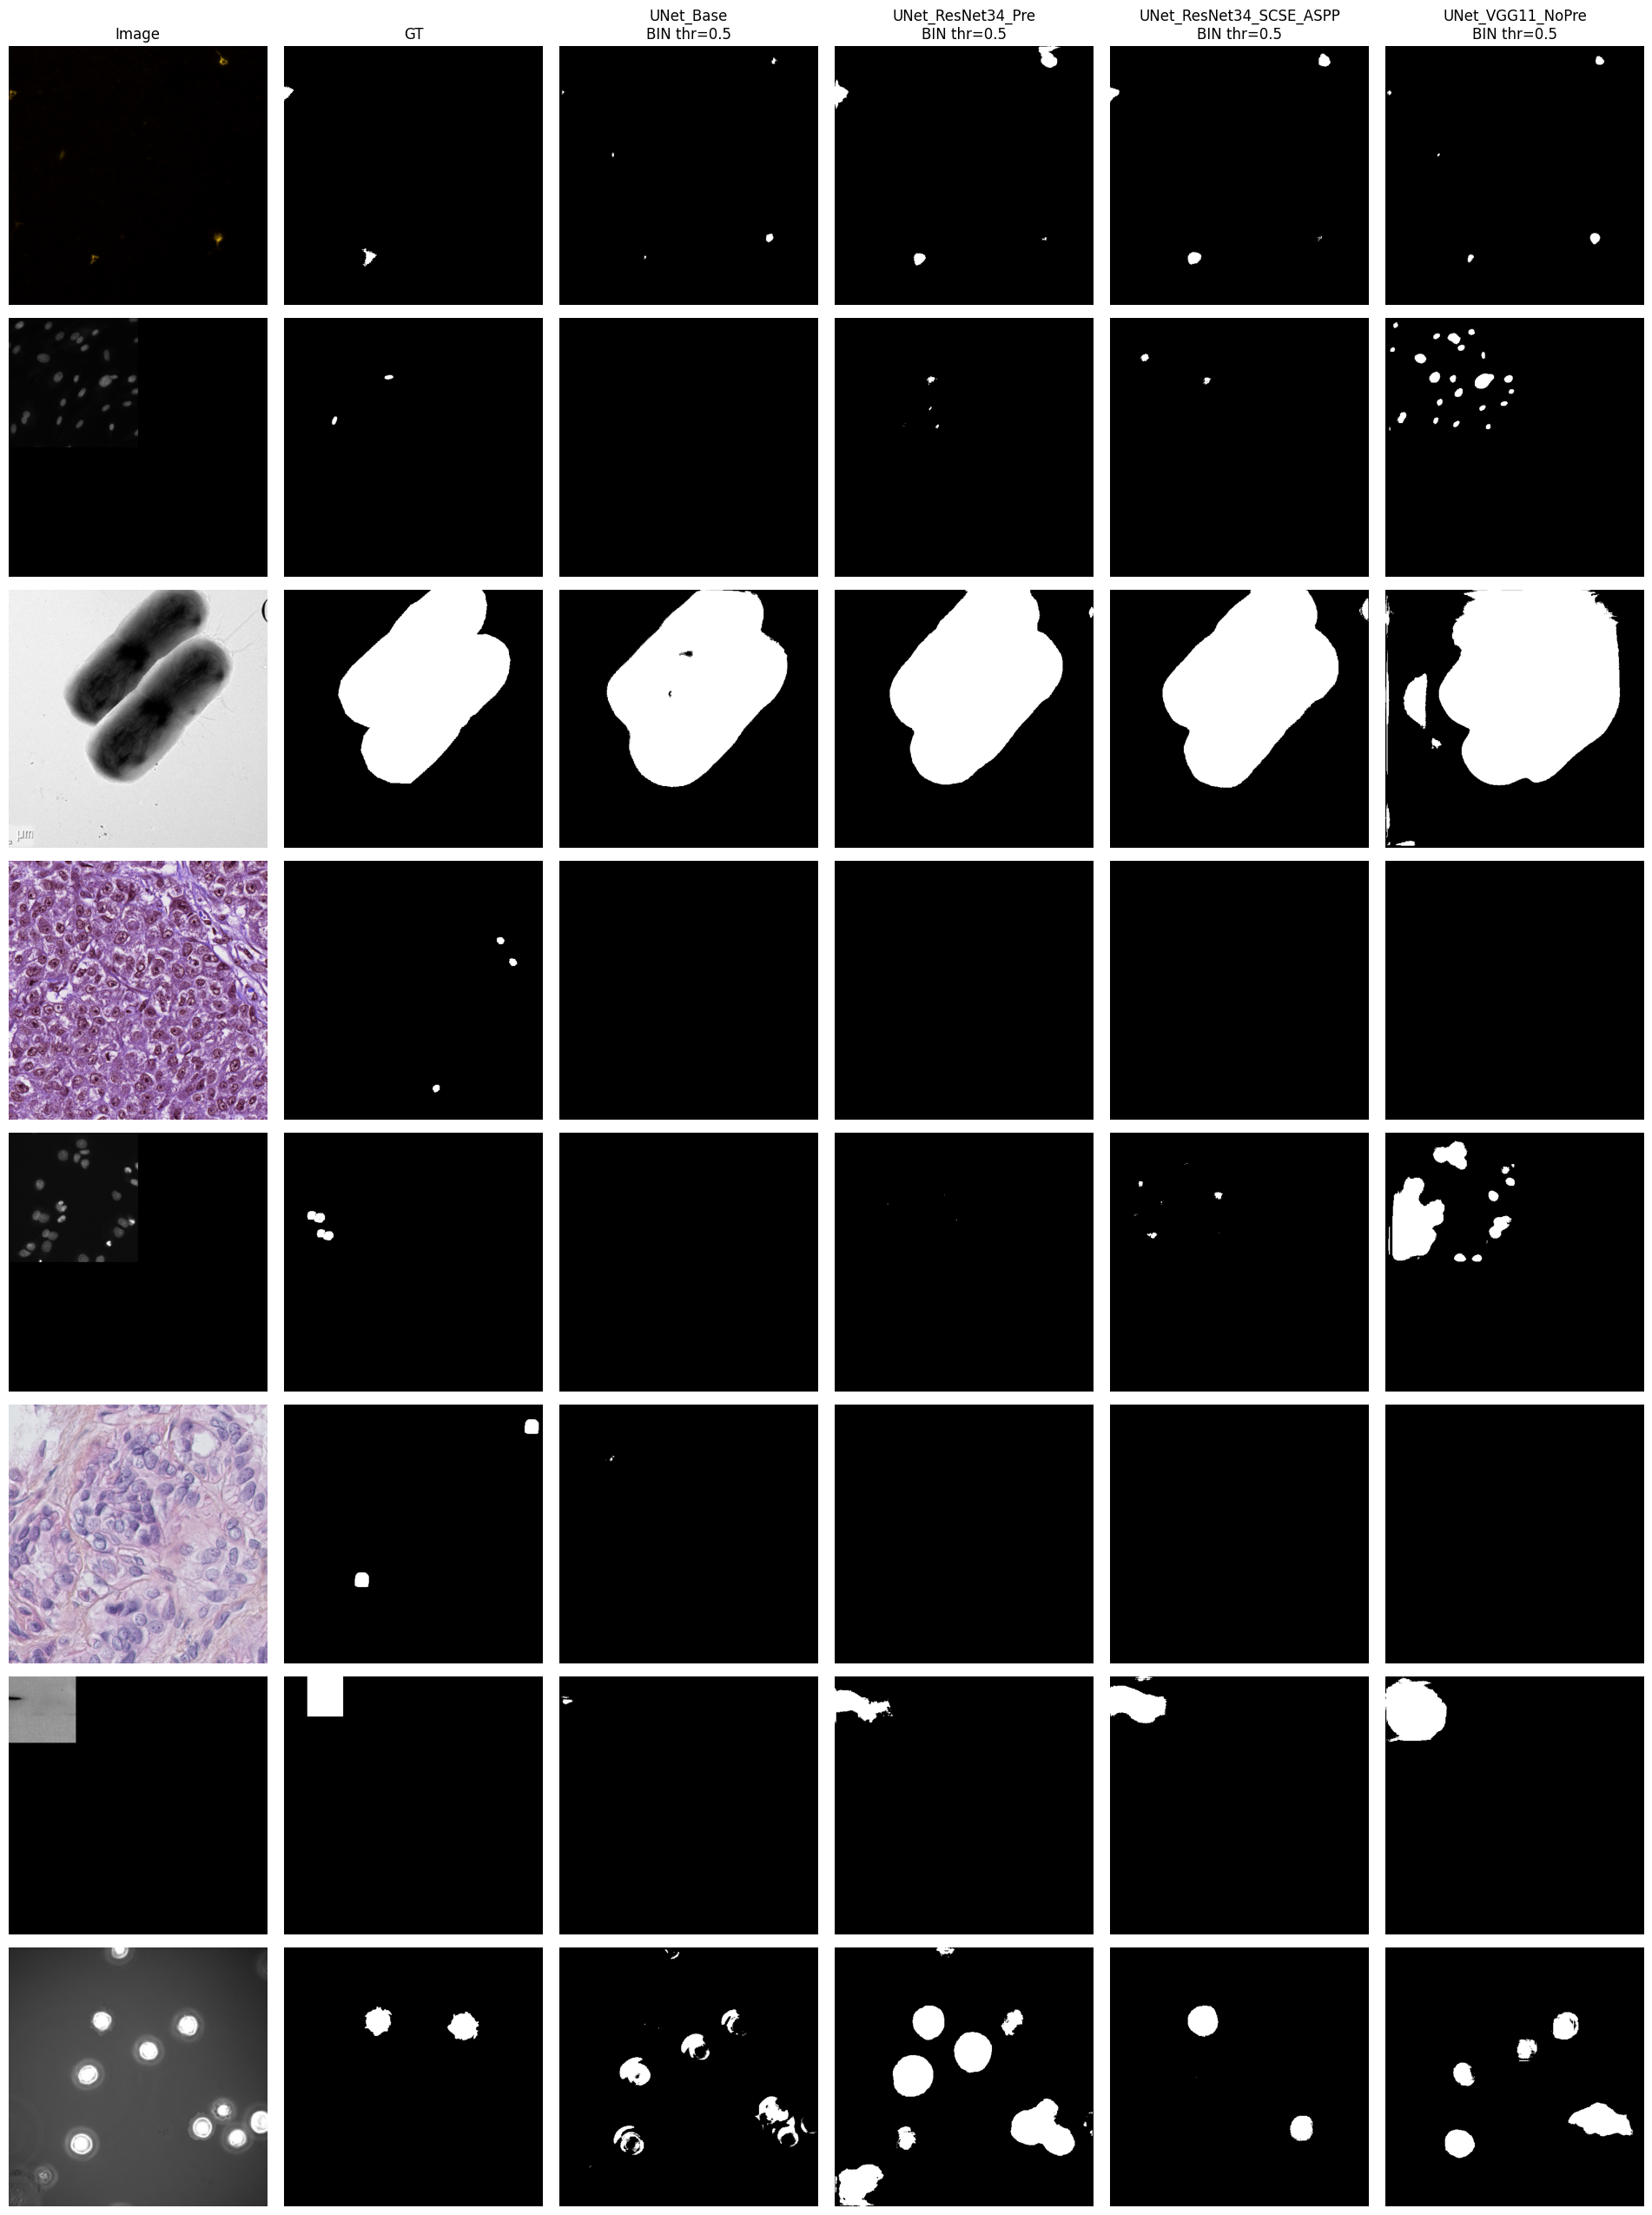

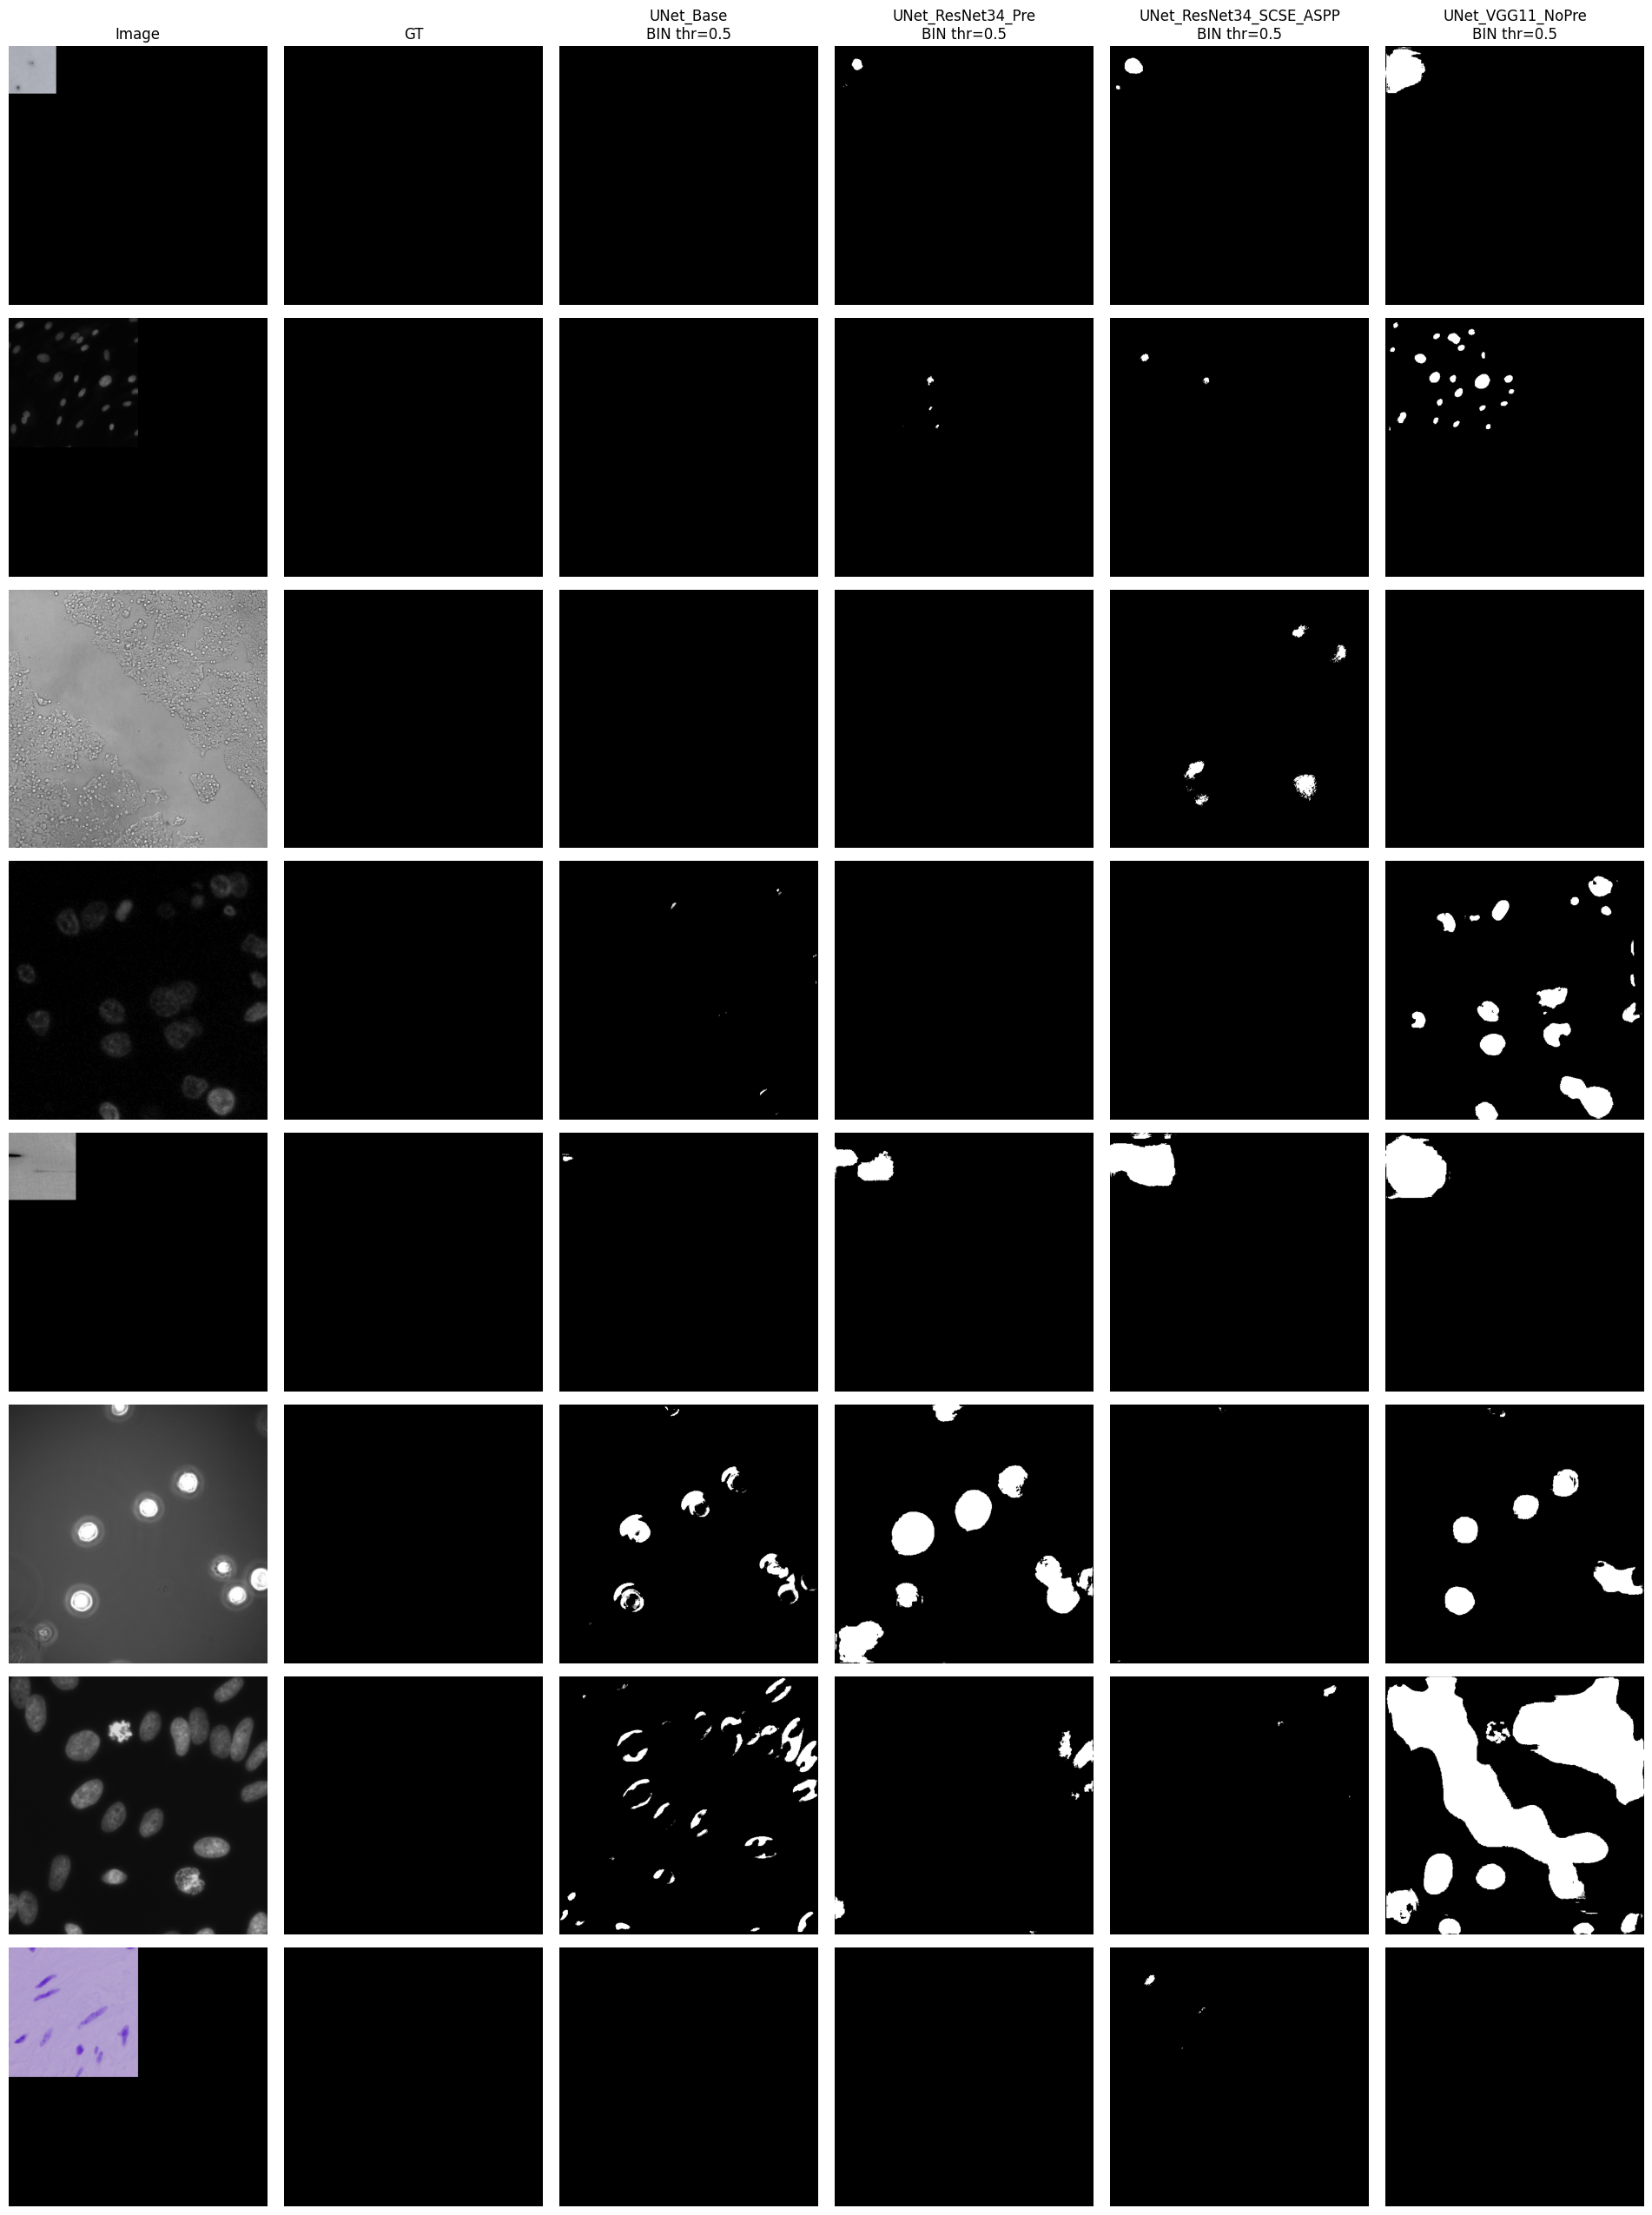

In [36]:
compare_models_bin_preds(
    models, loaders["val_f"], CFGA.device,
    n_images=10, thr=0.5,
    denorm_fn=denorm_imagenet,
    overlay=False
)

compare_models_bin_preds(
    models, loaders["val_a"], CFGA.device,
    n_images=10, thr=0.5,
    denorm_fn=denorm_imagenet,
    overlay=False
)

In [37]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def compare_models_bin_preds(
    models: dict,
    loader,
    device,
    n_images=10,
    idxs=None,
    thr=0.5,
    denorm_fn=None,
    overlay=False,
):
    imgs, gts = next(iter(loader))
    imgs = imgs.to(device)
    gts  = gts.to(device)

    B_total = imgs.size(0)

    if idxs is None:
        sel = list(range(min(n_images, B_total)))
    else:
        sel = [i for i in idxs if 0 <= i < B_total]
        if len(sel) == 0:
            raise ValueError(f"All idxs are out of range. Batch size={B_total}, idxs={idxs}")

    model_names = list(models.keys())
    M = len(model_names)

    preds_bin = {}
    for name in model_names:
        models[name].eval()
        logits = models[name](imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs > thr).float()
        preds_bin[name] = preds[:, 0].detach().cpu()

    extra = M if overlay else 0
    ncols = 2 + M + extra
    B = len(sel)

    fig, axes = plt.subplots(B, ncols, figsize=(3.2*ncols, 3.2*B))
    if B == 1:
        axes = axes.reshape(1, -1)

    axes[0, 0].set_title("Image")
    axes[0, 1].set_title("GT")
    for j, name in enumerate(model_names):
        axes[0, 2 + j].set_title(f"{name}\nBIN thr={thr}")
    if overlay:
        for j, name in enumerate(model_names):
            axes[0, 2 + M + j].set_title(f"{name}\nOverlay")

    for row, i in enumerate(sel):
        img_t = imgs[i].detach().cpu()
        if denorm_fn is not None:
            img_t = denorm_fn(img_t)
        img_np = img_t.permute(1,2,0).numpy()
        gt_np  = gts[i,0].detach().cpu().numpy()

        axes[row, 0].imshow(img_np); axes[row, 0].axis("off")
        axes[row, 1].imshow(gt_np, cmap="gray"); axes[row, 1].axis("off")

        for j, name in enumerate(model_names):
            pb = preds_bin[name][i].numpy()
            axes[row, 2 + j].imshow(pb, cmap="gray")
            axes[row, 2 + j].axis("off")

            if overlay:
                axes[row, 2 + M + j].imshow(img_np)
                axes[row, 2 + M + j].imshow(pb, cmap="Reds", alpha=0.35)
                axes[row, 2 + M + j].axis("off")

    plt.tight_layout()
    plt.show()


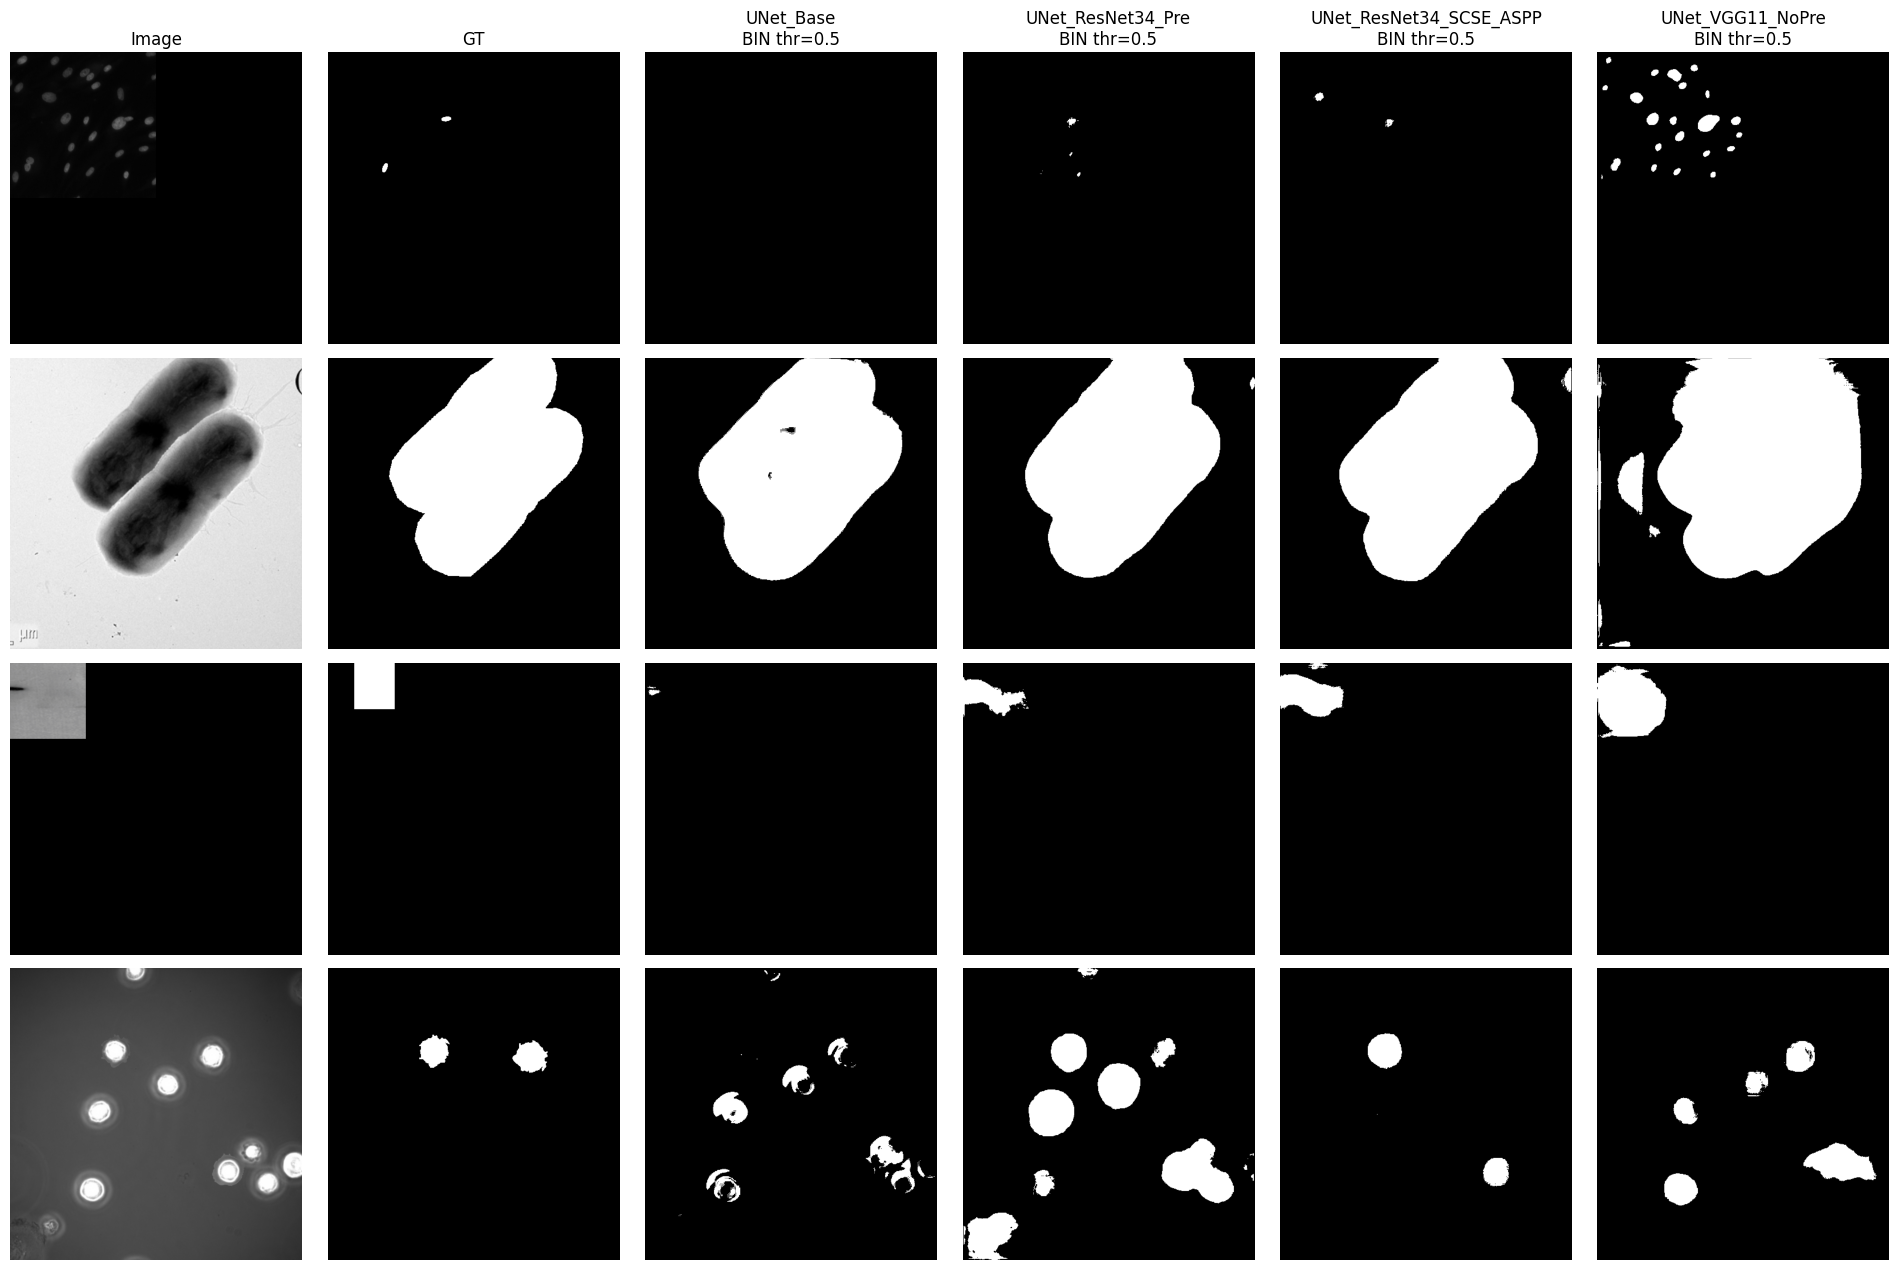

In [39]:
compare_models_bin_preds(
    models, loaders["val_f"], CFGA.device,
    idxs=[1,2, 6, 7],
    thr=0.5,
    denorm_fn=denorm_imagenet,
    overlay=False
)